# tutorial-mayavi-mlab-visualising-magnetisation

#### Author: Mark Vousden

#### Last Modified: 28/03/2014, tested on Mark's So'ton Desktop and his SP35P2Pro

This notebook is aimed at users of finmag who are not familiar Mayavi's scripting capabilities and who want to streamline the process of creating pretty graphics. In this notebook we will create some sample data and use Mayavi to display, render and save the image, all without touching your mouse (hopefully!). We will be producing plots with glyphs in this tutorial, but the procedure is very similar for surfaces and other such objects. Much of this information has been obtained from the well-written Mayavi documentation[1].

In [1]:
import dolfin as df
import finmag
from mayavi import __version__ as mayavi_version
from mayavi import mlab
import IPython.display
import numpy as np
import os

title = "tutorial-visualising-magnetisation-using-mayavi-mlab"

[2014-09-12 15:59:25] INFO: Finmag logging output will be appended to file: '/home/mb4e10/.finmag/global.log'
[2014-09-12 15:59:25] DEBUG: Building modules in 'native'...
[2014-09-12 15:59:26] DEBUG: FinMag          5453:7af0ebbcbc57aca5bd969bcbccca07cb0537b437
[2014-09-12 15:59:26] DEBUG: Dolfin          1.4.0                Matplotlib      1.3.1               
[2014-09-12 15:59:26] DEBUG: Numpy           1.8.1                Scipy           0.14.0              
[2014-09-12 15:59:26] DEBUG: IPython         2.1.0                Python          2.7.6               
[2014-09-12 15:59:26] DEBUG: Paraview        4.0.1-1ubuntu1       Sundials        2.5.0               
[2014-09-12 15:59:26] DEBUG: Boost-Python    <unknown>            Linux           Ubuntu 14.04.1 LTS  
[2014-09-12 15:59:26] DEBUG: Registering debug signal handler. Press Ctrl-Z at any time to stop execution and jump into the debugger.


In [2]:
# IPYTHON_TEST_IGNORE_OUTPUT
print "Mayavi Version: " + mayavi_version

Mayavi Version: 4.1.0


Firstly, lets create some simulation data. Pretty standard stuff.

In [3]:
# Create simulation object with single skyrmion magnetisation.
mesh = df.RectangleMesh(-100, -100, 100, 100, 20, 20)
sim = finmag.Simulation(mesh, 1e5, unit_length=1e-9)
sim.initialise_skyrmions(70)
    
# Obtain locations for sampling. "x", "y" and "z" are locations of vectors
# in 3D space. We set "z" to zero everywhere to show an example in 2D space
# for simplicity.
c = mesh.coordinates().transpose()
x, y = c[:]
z = np.zeros_like(x)

# Obtain vector directions. "u", "v" and "w" define the directions of the
# vectors given by the "x", "y" and "z" co-ordinates.
u = np.zeros_like(x)
v = np.zeros_like(x)
w = np.zeros_like(x)

for zI in xrange(len(x)):
    u[zI], v[zI], w[zI] = sim.llg._m_field.f(x[zI], y[zI])

[2014-09-12 15:59:31] INFO: Finmag logging output will be written to file: '/home/mb4e10/finmag/doc/ipython_notebooks_src/unnamed.log' (any old content will be overwritten).
[2014-09-12 15:59:31] DEBUG: Creating DataWriter for file 'unnamed.ndt'
[2014-09-12 15:59:31] INFO: Creating Sim object 'unnamed' (rank=0/1).
[2014-09-12 15:59:31] INFO: <Mesh of topological dimension 2 (triangles) with 441 vertices and 800 cells, ordered>
[2014-09-12 15:59:31] DEBUG: Creating LLG object.


So now we have some data that precisely describes our field of vectors. Now for the interesting part! We are going to draw some vectors and render them to the "scene" (an object that Mayavi uses "under the hood" of mlab). Whenever data is modified using mlab, the scene is update automatically for simplicity. So, let's draw some vectors:

In [ ]:
# Set offscreen rendering. This will still open a window, but nothing will be shown there.
mlab.options.offscreen = True

# Plot 3D vector field, and assign a reference scale to each vector equal to
# its out-of-plane component. Also use a colourmap that isn't hideous[2], though
# you can use your own custom colormap via the 'color' kwarg.
vectors = mlab.quiver3d(x, y, z, u, v, w, scalars=w, colormap="PuOr")

# We temporarily disable rendering to speed things up. This will be enabled again below.
# See http://docs.enthought.com/mayavi/mayavi/tips.html#accelerating-a-mayavi-script
vectors.scene.disable_render = True

# Colour vectors by the reference scale we included.
vectors.glyph.color_mode = 'color_by_scalar'

# Change the vectors to cones, because cones are awesome. NB <!>: I'm sure that
# there is a more elegant way of doing this, but I haven't found it yet.
cone_source = vectors.glyph.glyph_source.glyph_dict["cone_source"]
vectors.glyph.glyph_source.glyph_source = cone_source

# Resize the cones.
vectors.glyph.glyph_source.glyph_source.height = 0.4
vectors.glyph.glyph_source.glyph_source.radius = 0.2

# Reposition the cones relative to one-another (so that the result is flat). 
# Strange that this isn't the default setting, but there you go.
vectors.glyph.glyph_source.glyph_source.center = np.zeros(3)

# Set the resolution of objects.
vectors.glyph.glyph_source.glyph_source.resolution *= 6

# Re-enable rendering
vectors.scene.disable_render = False

# We also disable anti-aliasing for speed. This should not be done for high-quality plots.
# See http://docs.enthought.com/mayavi/mayavi/tips.html#accelerating-a-mayavi-script
vectors.scene.anti_aliasing_frames = 0

Now the cones are in the scene, we must look at them from a nice angle. Once there, we can save our image and enter interactive mode.

In [5]:
# Choose a useful camera angle. Angles given in degrees. Lots of options for
# this function, would recommend taking a look at the documentation especially
# if you want to create "rotating camera" animations.
mlab.view(azimuth=90., elevation=0., distance=350.)

# Save the image. The size, output format (deduced by the filename) and
# magnification can be customised here.
mlab.savefig(title + "-output.png")

# Enable interactivity.
#mlab.show()

This is what the generated image looks like (it would be slightly nicer with anti-aliasing enabled, but it already looks quite good).

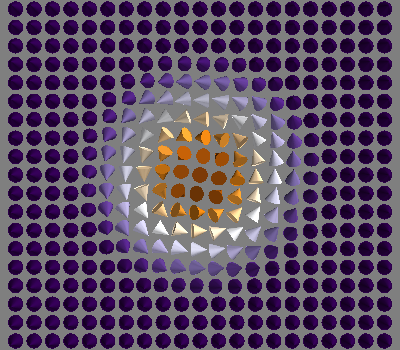

In [6]:
IPython.display.Image(title + "-output.png")

In this example, I have created the glyphs before moving the camera. This is a bad move if we want to automate the process since the glyphs need to be rendered on each action. Two alternatives are present: create the glyphs at the end, or render the whole image only at the end of the process (see the advanced tutorial).

You may (or may not) want to look at performing advanced scripting techniques using a more object-oriented approach. This predominantly requires using an instance of the mayavi.engine class and manipulating the pipeline directly [3]. If you use the recording feature of Mayavi, you will see these advanced techniques in action. Using this approach, it becomes a lot easier to change properties of a figure, such as the colour of the background.

### References:

[1] http://docs.enthought.com/mayavi/mayavi/

[2] http://woozyvoozie.wordpress.com/2014/02/19/the-rainbow-colourmap-and-an-apology/

[3] http://docs.enthought.com/mayavi/mayavi/advanced_scripting.html 